10
70


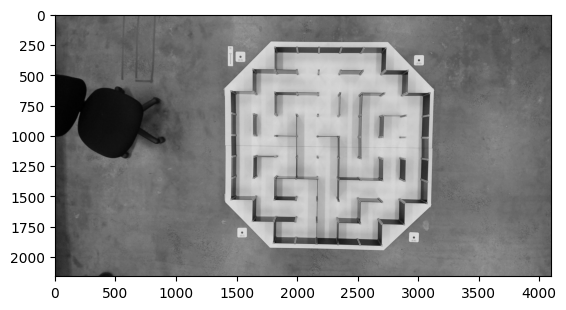

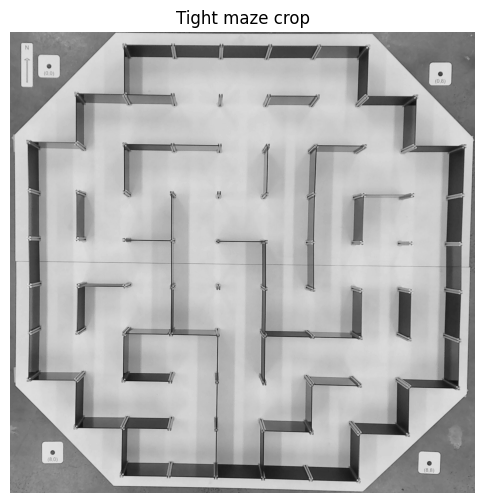

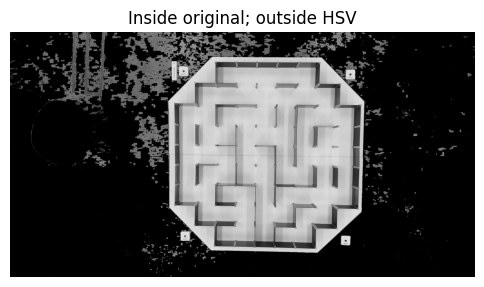

In [377]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

start_row_idx = 1
start_col_idx = 1
start_dir = 'S'

goal_row_idx = 7
goal_col_idx = 7
goal_dir = 'E'

random.seed(42)
#cv2.imwrite("maze_img0.png", img)
seed = 42
image_file = "mraw.jpg"
threshold_value = 150 # for the occupancy map
autocrop_threshold_value = 145 # for the autocrop adjustment/finetuning
unsafe_kernel_size = 7
unsafe_iterations = 3

# Edge detection parameters
canny_low_threshold = 50
canny_high_threshold = 150
sobel_threshold = 50

# Task 3 - BFS
bfs_n = 9  # Wall grid size (kept for reference)
# bfs_start_node = 36  # Start node (0 to 80 for 9x9 grid)
# bfs_end_node = 61   # End node (0 to 80 for 9x9 grid)

bfs_start_node = start_row_idx * 9 + start_col_idx
bfs_end_node = goal_row_idx * 9 + goal_col_idx

print(bfs_start_node)
print(bfs_end_node)

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 30
prm_connection_radius = 200
prm_start_node = 20            # Start node using same grid system as BFS (0 to 80 for 9x9 grid)
prm_end_node = 60              # End node using same grid system as BFS (0 to 80 for 9x9 grid)


# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Display resulting image
plt.imshow(image, cmap = 'gray')
plt.show()

def _contours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE):
    """Version-agnostic cv2.findContours: always returns the contours list."""
    found = cv2.findContours(img, mode, method)
    return found[0] if len(found) == 2 else found[1]

def _find_big_octagon_contour(img_bgr):
    """Edge/contour search for the big board; prefer ~octagon near image center."""
    H, W = img_bgr.shape[:2]
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5,5), 0)
    edge = cv2.Canny(g, 50, 150)
    edge = cv2.dilate(edge, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), 2)

    # ✅ use the helper so it works on OpenCV 3 or 4
    cnts = _contours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    cx0, cy0 = W/2.0, H/2.0
    best, best_score = None, -1e18
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 0.05 * W * H:   # ignore small blobs
            continue

        x, y, w, h = cv2.boundingRect(c)
        ar_pen = abs(np.log(max(w,1) / float(max(h,1))))  # squareness penalty

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        verts = len(approx)

        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]
        d2 = (cx - cx0)*2 + (cy - cy0)*2

        # prefer big, near center, ~8 sides, square-ish bbox
        score = 0.06*area - 0.001*d2 - 6.0*abs(verts - 8) - 8.0*ar_pen
        if score > best_score:
            best_score, best = score, approx

    if best is None:
        cmax = max(cnts, key=cv2.contourArea)
        best = cv2.approxPolyDP(cmax, 0.02 * cv2.arcLength(cmax, True), True)

    return best.reshape(-1, 2).astype(np.int32)

def _white_by_hsv(img_bgr, s_max=120, v_min=85):
    """White/near-white mask using ONLY HSV (low S, high V)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    S, V = hsv[:,:,1], hsv[:,:,2]
    mask = np.where((S <= s_max) & (V >= v_min), 255, 0).astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, 1)
    return mask

def _shrink_until_white(poly_mask, white_mask, target_white=0.65, max_iter=40):
    """Iteratively erode polygon mask until enough HSV-white inside."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    m = poly_mask.copy()
    best, best_ratio = m, 0.0
    for _ in range(max_iter):
        inside = (m==255)
        area = int(inside.sum())
        if area == 0: break
        ratio = float((white_mask[inside]==255).sum()) / area
        if ratio > best_ratio: best_ratio, best = ratio, m.copy()
        if ratio >= target_white: return m
        m = cv2.erode(m, kernel, 1)
    return best

def isMaze(img_bgr,
           hsv_low=(30,0,39), hsv_high=(130,255,255),
           white_s_max=120, white_v_min=85,
           white_target=0.65, max_shrink=40,
           erode_k=9, erode_iter=1, margin_px=8):
    """
    Returns: dict with keys
      'mask'            : final octagon mask (0/255)
      'crop_rect'       : (x1,y1,x2,y2)
      'cropped_gray'    : crop from ORIGINAL grayscale (inside unchanged)
      'composite_gray'  : full image: HSV filtering applied only OUTSIDE the octagon
    """
    H,W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 1) initial octagon from edges/contours
    poly = _find_big_octagon_contour(img_bgr)
    if poly is None:
        # nothing found: return passthrough
        return {"mask": np.zeros((H,W), np.uint8), "crop_rect": (0,0,W,H),
                "cropped_gray": gray.copy(),
                "composite_gray": gray.copy()}

    poly_mask = np.zeros((H,W), np.uint8)
    cv2.fillPoly(poly_mask, [poly], 255)

    # 2) HSV-white mask and shrink polygon until white fraction is high
    white_mask = _white_by_hsv(img_bgr, s_max=white_s_max, v_min=white_v_min)
    final_mask = _shrink_until_white(poly_mask, white_mask,
                                     target_white=white_target, max_iter=max_shrink)

    # optional tiny tightening then small outward margin in crop
    if erode_iter > 0:
        final_mask = cv2.erode(final_mask,
                               cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erode_k,erode_k)),
                               erode_iter)

    ys, xs = np.where(final_mask==255)
    if len(xs)==0:
        x1,y1,x2,y2 = 0,0,W,H
    else:
        x1 = max(0, xs.min()-margin_px);  y1 = max(0, ys.min()-margin_px)
        x2 = min(W, xs.max()+1+margin_px); y2 = min(H, ys.max()+1+margin_px)

    # 3) HSV filter for OUTSIDE only
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    outside_mask = cv2.inRange(hsv, np.array(hsv_low,np.uint8), np.array(hsv_high,np.uint8))
    outside_bgr  = cv2.bitwise_and(img_bgr, img_bgr, mask=outside_mask)

    composite = img_bgr.copy()
    outside = (final_mask==0)
    composite[outside] = outside_bgr[outside]

    return {
        "mask": final_mask,
        "crop_rect": (x1,y1,x2,y2),
        "cropped_gray": gray[y1:y2, x1:x2],
        "composite_gray": cv2.cvtColor(composite, cv2.COLOR_BGR2GRAY)
    }

# 0) Load
img_color = cv2.imread(image_file, cv2.IMREAD_COLOR)
assert img_color is not None

# 1) Your HSV range (outside processing)
H_low, H_high = 30, 130
S_low, S_high = 0, 255
V_low, V_high = 39, 255

out = isMaze(
    img_color,
    hsv_low=(H_low,S_low,V_low),
    hsv_high=(H_high,S_high,V_high),
    white_s_max=120,     # how permissive 'white' is (↑ for strong shadows)
    white_v_min=85,      # min brightness for 'white'
    white_target=0.65,   # raise if you want the polygon to hug the wall more
    max_shrink=40,
    erode_k=9, erode_iter=1, margin_px=8
)

x1,y1,x2,y2 = out["crop_rect"]
cropped      = out["cropped_gray"]
composite    = out["composite_gray"]   # full frame, HSV only outside octagon

# 2) Display
plt.figure(figsize=(6,6)); plt.imshow(cropped, cmap='gray'); plt.axis('off'); plt.title('Tight maze crop'); plt.show()
plt.figure(figsize=(6,6)); plt.imshow(composite, cmap='gray'); plt.axis('off'); plt.title('Inside original; outside HSV'); plt.show()

# keep using ⁠ image ⁠ if your downstream expects it
image = cropped

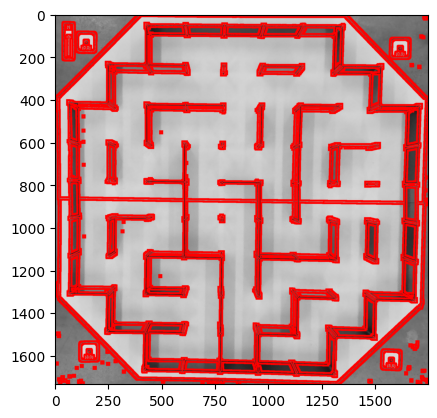

In [378]:
# --- Binarize, remove central horizontal seam, then build buffer zone & overlay ---

pixel_detection = 11
# If too much is being detected, increase this (more strict). If too little is being detected, decrease this (less strict)
detection_strictness = 10


# 1) Adaptive threshold (walls -> 255)
cropped_blur = cv2.medianBlur(cropped, 3)
binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    pixel_detection, detection_strictness
)


h, w = binary_obstacles.shape[:2]

# 3) Dilation + buffer zone
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# 4) Visualize (red buffer)
colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]
plt.imshow(colour_image); plt.show()

# # 2) Detect long horizontal lines near the vertical center and erase them
# seam_mask = np.zeros_like(binary_obstacles)

# # Hough on edges within a central band
# band_top = int(0.35 * h)
# band_bot = int(0.65 * h)
# edges = cv2.Canny(cropped_blur, 30, 90)
# edges_mid = np.zeros_like(edges)
# edges_mid[band_top:band_bot, :] = edges[band_top:band_bot, :]

# lines = cv2.HoughLinesP(
#     edges_mid, rho=1, theta=np.pi/180, threshold=50,
#     minLineLength=int(0.50 * w), maxLineGap=25
# )

# if lines is not None:
#     thick = max(5, int(0.01 * min(h, w)))
#     for x1, y1, x2, y2 in lines[:, 0]:
#         ang = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
#         if (ang < 12) or (ang > 168):  # near-horizontal
#             cv2.line(seam_mask, (x1, y1), (x2, y2), 255, thickness=thick)

# # Morphological fallback: long+thin components in the same central band
# if not np.any(seam_mask):
#     mid_band = np.zeros_like(binary_obstacles)
#     mid_band[band_top:band_bot, :] = binary_obstacles[band_top:band_bot, :]
#     klen = max(31, w // 4)  # long horizontal kernel
#     hker = cv2.getStructuringElement(cv2.MORPH_RECT, (klen, 3))
#     mid_closed = cv2.morphologyEx(mid_band, cv2.MORPH_CLOSE, hker, iterations=1)

#     num, labels, stats, _ = cv2.connectedComponentsWithStats(mid_closed, connectivity=8)
#     thin_px = max(5, int(0.1 * h))
#     min_len = int(0.05 * w)
#     for i in range(1, num):
#         x, y, ww, hh, area = stats[i]
#         if (ww >= min_len) and (hh <= thin_px) and (band_top <= y <= band_bot):
#             comp = (labels == i).astype(np.uint8) * 255
#             comp = cv2.dilate(comp, np.ones((3, 3), np.uint8), iterations=1)
#             seam_mask = cv2.bitwise_or(seam_mask, comp)

# # Erase detected seam from the binary mask (walls are 255)
# binary_obstacles[seam_mask > 0] = 0


# if not np.any(seam_mask):
#     # 1) build a tighter central band to reduce false hits
#     mid = h // 2
#     band_half = max(3, int(0.05 * h))           # ±5% of height
#     band_top  = max(0, mid - band_half)
#     band_bot  = min(h, mid + band_half)

#     mid_band = np.zeros_like(binary_obstacles)
#     mid_band[band_top:band_bot, :] = (binary_obstacles[band_top:band_bot, :])

#     # 2) extract thin horizontals (TOPHAT with long, 1-px tall kernel)
#     klen = max(15, int(0.25 * w))               # ~25% of width
#     if klen % 2 == 0: klen += 1
#     hker = cv2.getStructuringElement(cv2.MORPH_RECT, (klen, 1))
#     mid_feat = cv2.morphologyEx(mid_band, cv2.MORPH_TOPHAT, hker, iterations=1)

#     # 3) select long + thin components (percent-based)
#     min_len_frac   = 0.01                        # ≥60% of width
#     max_thick_frac = 0.05                        # ≤6% of height
#     min_len_px     = int(min_len_frac * w)
#     max_thin_px    = max(5, int(max_thick_frac * h))

#     num, labels, stats, _ = cv2.connectedComponentsWithStats(mid_feat, connectivity=8)

#     picked = False
#     for i in range(1, num):
#         x, y, ww, hh, area = stats[i]
#         if (ww >= min_len_px) and (hh <= max_thin_px) and (band_top <= y <= band_bot):
#             comp = (labels == i).astype(np.uint8) * 255
#             # thicken a bit to ensure full erase of the seam
#             comp = cv2.dilate(comp, np.ones((3, 3), np.uint8), iterations=1)
#             seam_mask = cv2.bitwise_or(seam_mask, comp)
#             picked = True

#     # 4) last-ditch: row coverage in the tight band (handles broken/haloy JPEG seams)
#     if not picked:
#         rows = (binary_obstacles[band_top:band_bot, :] == 255)
#         coverage = rows.sum(axis=1) / float(w)
#         min_row_cov = 0.70                      # row must be ≥70% "wall"
#         idx = np.flatnonzero(coverage >= min_row_cov)
#         if idx.size:
#             y1 = band_top + int(idx[0])
#             y2 = band_top + int(idx[-1])
#             # clamp thickness so we don't nuke real walls
#             max_thick = max(3, int(0.08 * h))   # ≤8% of height
#             if (y2 - y1 + 1) > max_thick:
#                 midrow = (y1 + y2) // 2
#                 y1 = max(0, midrow - max_thick // 2)
#                 y2 = min(h - 1, y1 + max_thick - 1)
#             seam_mask[y1:y2+1, :] = 255
        

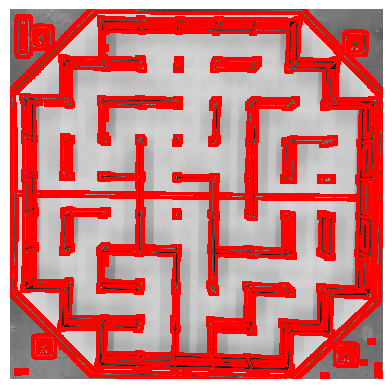

In [379]:
# --- Size-aware thresholding + size-aware buffer ring ---

h, w = cropped.shape[:2]
m   = min(h, w)

# Helper to force odd kernel sizes
def odd(k): 
    k = int(k)
    return k + 1 if k % 2 == 0 else k

# 1) Pre-filter scaled to image size (median over ~0.3% of min side)
k_med = odd(max(3, int(0.003 * m)))
cropped_blur = cv2.medianBlur(cropped, k_med)

# # 2) Adaptive threshold with block size as ~3% of min side (must be odd, >=3)
# block_frac = 0.03                     # tweak 0.02–0.06 if needed
# blockSize  = odd(max(3, int(block_frac * m)))
# C          = int(0.06 * 255)          # ~15; intensity offset (not size-dependent)

# binary_obstacles = cv2.adaptiveThreshold(
#     cropped_blur, 255,
#     cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
#     blockSize, C
# )

def odd(n: int) -> int:
    # Make sure block size is an odd integer ≥ 3
    n = max(3, int(n))
    return n if n % 2 == 1 else n + 1

# TUNE THESE TWO
pixel_detection     = 51   # block size (local window) → MUST be odd
detection_strictness = 25  # C (offset) → larger = stricter (fewer white pixels for THRESH_BINARY_INV)

cropped_blur = cv2.medianBlur(cropped, 3)

binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    odd(pixel_detection), detection_strictness
)

# 3) Buffer ring width as a fraction of image size
margin_frac = 0.010                    # ~1% of min side; tweak 0.006–0.015
margin_px   = max(1, int(margin_frac * m))

# Option A: dilation-based ring (simple; ring ≈ margin_px)
kernel = np.ones((2 * margin_px + 1, 2 * margin_px + 1), np.uint8)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=1)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# ---- OR ----
# Option B: exact-width ring via distance transform (consistent thickness)
# free = cv2.bitwise_not(binary_obstacles)
# dist = cv2.distanceTransform(free, cv2.DIST_L2, 3)
# buffer_zone = np.zeros_like(binary_obstacles, dtype=np.uint8)
# buffer_zone[(dist > 0) & (dist <= margin_px)] = 255

# 4) Visualize (red buffer)
colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]
plt.imshow(colour_image, interpolation='nearest'); plt.axis('off'); plt.show()

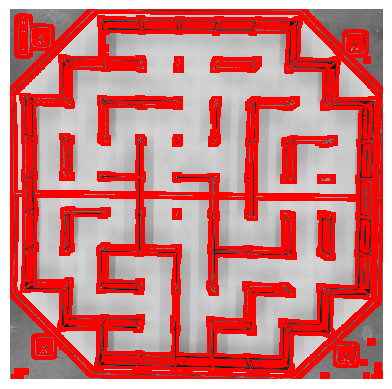

In [380]:
h, w = cropped.shape[:2]
m   = min(h, w)

def odd(n: int) -> int:
    n = max(3, int(n))
    return n if n % 2 == 1 else n + 1

# --- 1) Blur + adaptive threshold (same knobs as before) ---
pixel_detection      = 51   # MUST be odd (function forces it)
detection_strictness = 22   # larger => stricter (thinner walls)

cropped_blur = cv2.medianBlur(cropped, 3)
binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    odd(pixel_detection), detection_strictness
)

# --- 2) Remove a horizontal seam near the vertical center (percent-based) ---
mid = h // 2
band_half = max(3, int(0.04 * h))     # search only in ±4% band around center
band_top  = max(0, mid - band_half)
band_bot  = min(h, mid + band_half)

rows = (binary_obstacles[band_top:band_bot, :] == 255)  # 255=wall after THRESH_BINARY_INV
coverage = rows.sum(axis=1) / float(w)                  # fraction of row that's "wall"
min_row_cov = 0.20                                      # row looks like seam if ≥60% wall

mask = coverage >= min_row_cov
if np.any(mask):
    idx = np.flatnonzero(mask)
    # split into contiguous segments
    splits = np.where(np.diff(idx) > 1)[0] + 1
    segments = np.split(idx, splits)

    # choose the segment closest to the exact midline, but not too thick
    max_thick = max(3, int(0.08 * h))                   # cap seam thickness at 8% of height
    best = None; best_dist = 1e9
    for seg in segments:
        y1 = band_top + int(seg[0])
        y2 = band_top + int(seg[-1])
        thick = y2 - y1 + 1
        if thick <= max_thick:
            dist = abs((y1 + y2)/2.0 - (h/2.0))
            if dist < best_dist:
                best = (y1, y2); best_dist = dist

    if best is not None:
        y1, y2 = best
        pad = max(1, int(0.005 * h))                    # tiny padding for JPEG halos
        y1 = max(0, y1 - pad); y2 = min(h-1, y2 + pad)
        binary_obstacles[y1:y2+1, :] = 0                # erase the seam

# --- 3) Buffer ring (scaled to image size for consistent look) ---
margin_frac = 0.010                    # ~1% of min side
margin_px   = max(1, int(margin_frac * m))

kernel = np.ones((2 * margin_px + 1, 2 * margin_px + 1), np.uint8)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=1)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# --- 4) Visualize (red = buffer ring) ---
colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]
plt.imshow(colour_image, interpolation='nearest'); plt.axis('off'); plt.show()

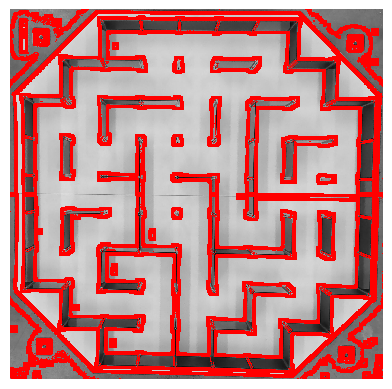

In [382]:
h, w = cropped.shape[:2]

def odd_from_frac(frac: float, base: str = "min", min_px: int = 3) -> int:
    """
    Convert a fraction of an axis into an odd kernel size.
    base: "min" | "w" | "h" → which axis to scale from.
    """
    base_len = {"min": min(h, w), "w": w, "h": h}[base]
    k = max(min_px, int(round(frac * base_len)))
    return k if k % 2 == 1 else k + 1

# --- tune these as FRACTIONS of image size ---
blur_frac   = 0.00005   # ~0.3% of chosen axis
block_frac  = 0.1    # ~3% of chosen axis for adaptive block
C           = 15      # intensity offset (not geometric)

# choose which axis to scale by: "min" (recommended), or "w"/"h"
axis = "min"

k_med    = odd_from_frac(blur_frac,  base=axis)
blockSize = odd_from_frac(block_frac, base=axis)

# Blur + adaptive threshold using size-relative kernels
cropped_blur = cv2.medianBlur(cropped, k_med)
binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    blockSize, C
)

# --- 2) Remove a horizontal seam near the vertical center (percent-based) ---
mid = h // 2
band_half = max(3, int(0.04 * h))     # search only in ±4% band around center
band_top  = max(0, mid - band_half)
band_bot  = min(h, mid + band_half)

rows = (binary_obstacles[band_top:band_bot, :] == 255)  # 255=wall after THRESH_BINARY_INV
coverage = rows.sum(axis=1) / float(w)                  # fraction of row that's "wall"
min_row_cov = 0.20                                      # row looks like seam if ≥60% wall

mask = coverage >= min_row_cov
if np.any(mask):
    idx = np.flatnonzero(mask)
    # split into contiguous segments
    splits = np.where(np.diff(idx) > 1)[0] + 1
    segments = np.split(idx, splits)

    # choose the segment closest to the exact midline, but not too thick
    max_thick = max(3, int(0.08 * h))                   # cap seam thickness at 8% of height
    best = None; best_dist = 1e9
    for seg in segments:
        y1 = band_top + int(seg[0])
        y2 = band_top + int(seg[-1])
        thick = y2 - y1 + 1
        if thick <= max_thick:
            dist = abs((y1 + y2)/2.0 - (h/2.0))
            if dist < best_dist:
                best = (y1, y2); best_dist = dist

    if best is not None:
        y1, y2 = best
        pad = max(1, int(0.005 * h))                    # tiny padding for JPEG halos
        y1 = max(0, y1 - pad); y2 = min(h-1, y2 + pad)
        binary_obstacles[y1:y2+1, :] = 0                # erase the seam

# --- 3) Buffer ring (scaled to image size for consistent look) ---
margin_frac = 0.010                    # ~1% of min side
margin_px   = max(1, int(margin_frac * m))

kernel = np.ones((2 * margin_px + 1, 2 * margin_px + 1), np.uint8)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=1)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# --- 4) Visualize (red = buffer ring) ---
colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]
plt.imshow(colour_image, interpolation='nearest'); plt.axis('off'); plt.show()

In [383]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = []

    def add_edge(self, node_id1, node_id2, weight):
        self.edges[node_id1].append((node_id2, weight))
        self.edges[node_id2].append((node_id1, weight))

    def remove_edge(self, node_id1, node_id2):
        for i in self.edges[node_id1]:
            if i[0] == node_id2:
                index1 = i;
        for i in self.edges[node_id2]:
            if i[0] == node_id1:
                index2 = i;
                
        self.edges[node_id1].remove(index1)
        self.edges[node_id2].remove(index2)
    
    def get_nodes(self):
        return self.nodes
    
    def get_edges(self):
        return self.edges
    
    def get_edge_weight(self, node_id1, node_id2):
        for i in self.edges[node_id1]:
            if i[0] == node_id2:
                return i[1]

In [384]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):

    ROI = image[y1:y2, x1:x2]
    
    for i in ROI:
        for j in i:
            if (j == [255, 0, 0]).all() or (j == [0, 0, 0]).all():
                return False
    
    return True

1734
1734


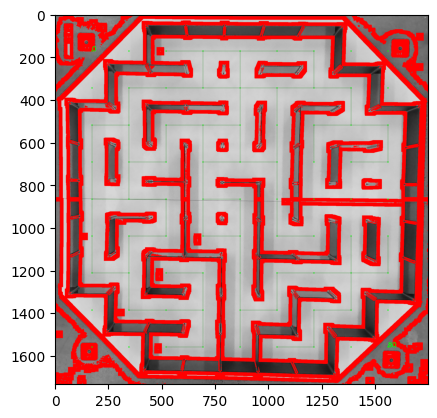

In [385]:
bfs_image = colour_image
bfs_graph = Graph()

# If you want the whole image’s side-length (in pixels):
h, w = bfs_image.shape[:2]     # bfs_image must be a NumPy array
side_length = min(h, w) # if it’s square this equals both
print(side_length)

# If you want the cropped/maze ROI’s side-length:
side_length = min(cropped.shape[:2])
print(side_length)

# side_length = 1180
gap = side_length/(bfs_n + 1)
width = 1
radius = 3
id = 0;

# Adding Nodes
for i in range(1, bfs_n + 1):
    y = i*gap
    for j in range(1, bfs_n + 1):
        x = j*gap
        bfs_graph.add_node(id, x, y)
        id+=1
        
nodes = bfs_graph.get_nodes()

# Adding Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
    
    if (j % bfs_n) != (bfs_n - 1):
        if path_clear(bfs_image, x, y, right, y + 1):
            id2 = j + 1
            bfs_graph.add_edge(j, id2, 1)

    if j < id - bfs_n:
        if path_clear(bfs_image, x, y, x + 1, down):
            id2 = j + bfs_n
            bfs_graph.add_edge(j, id2, 1)
    
    # Draw Nodes
    cv2.circle(bfs_image,(int(x),int(y)), 3, (0,255,0), -1)

# Draw Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
        
    for edge in bfs_graph.edges[node.id]:
        partner_id = edge[0]
        partner_node = bfs_graph.nodes[partner_id]
        
        cv2.line(bfs_image,(int(x), int(y)),(int(partner_node.x), int(partner_node.y)),(0, 125, 0), 1)


font = cv2.FONT_HERSHEY_SIMPLEX

first_node = bfs_graph.nodes[0]
cv2.putText(bfs_image,str(first_node.id),(int(first_node.x),int(first_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

last_node = bfs_graph.nodes[id - 1]
cv2.putText(bfs_image,str(last_node.id),(int(last_node.x),int(last_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

# Display Resulting Image
plt.imshow(bfs_image)
plt.show()

In [386]:
# Task 3.2 (5 marks): Implement BFS

# Returns an array of nodes in order of which nodes are visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]

def bfs(graph, start_node_id, end_node_id):
    
    visited = []
    Q = [start_node_id]
    parent = {}
    path = []
    
    while Q:

        current = Q.pop(0)
        visited.append(current)
        
        # Find all the connected nodes and add to Q
        for partner in graph.edges[current]:
            partner_id = partner[0]
            
            if partner_id not in visited and partner_id not in Q:
                # Make the current the parent to the partners
                parent[partner_id] = current
                Q.append(partner_id)
    
    current = end_node_id
    
    # Create the path by going backwards to the parent
    while True:
        path.append(current)
        if current == start_node_id:
            break
        current = parent[current]
    
    # Reverse to go in forwards direction
    path.reverse()
    return path

In [276]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

for i in range(len(path)):
    
    current_x = int(bfs_graph.nodes[path[i]].x)
    current_y = int(bfs_graph.nodes[path[i]].y)
    if i + 1 < len(path):
        next_x = int(bfs_graph.nodes[path[i + 1]].x)
        next_y = int(bfs_graph.nodes[path[i + 1]].y)
        cv2.line(bfs_image,(current_x, current_y),(next_x, next_y),(0, 0, 125), 3)

# Display the resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

KeyError: 70

In [ ]:
# def generate_robot_commands(graph, path):
#     """
#     Minimal path->command conversion.
#     Assumes 4-connected grid, image coords (x right, y down).
#     Robot starts facing the first movement direction.
#     Returns: (command_string, command_list)
#     """
#     if len(path) < 2:
#         return "", []

#     # Clockwise order: EAST, SOUTH, WEST, NORTH
#     DIRS = [(1, 0), (0, 1), (-1, 0), (0, -1)]

#     def unit_step(a, b):
#         dx = b.x - a.x
#         dy = b.y - a.y
#         dx = 0 if dx == 0 else (1 if dx > 0 else -1)
#         dy = 0 if dy == 0 else (1 if dy > 0 else -1)
#         step = (dx, dy)
#         if step not in DIRS and step != (0, 0):
#             raise ValueError(f"Non-cardinal step in path: {step}")
#         return step

#     # Build move directions (skip zero-length hops if any)
#     moves = []
#     for i in range(len(path) - 1):
#         a = graph.nodes[path[i]]
#         b = graph.nodes[path[i + 1]]
#         s = unit_step(a, b)
#         if s != (0, 0):
#             moves.append(s)

#     if not moves:
#         return "", []

#     # Start facing first move
#     cmds = ["F"]
#     cmd_str = "F"
#     cur_idx = DIRS.index(moves[0])

#     # Subsequent moves -> turns + F
#     for s in moves[1:]:
#         nxt_idx = DIRS.index(s)
#         diff = (nxt_idx - cur_idx) % 4  # 0:F, 1:RF, 2:RRF, 3:LF
#         if diff == 0:
#             cmds.append("F"); cmd_str += "F"
#         elif diff == 1:
#             cmds.extend(["R", "F"]); cmd_str += "RF"; cur_idx = nxt_idx
#         elif diff == 2:
#             cmds.extend(["R", "R", "F"]); cmd_str += "RRF"; cur_idx = nxt_idx
#         else:  # diff == 3
#             cmds.extend(["L", "F"]); cmd_str += "LF"; cur_idx = nxt_idx

#     return cmd_str, cmds

def generate_robot_commands(graph, path, start_dir: str, goal_dir: str):
    """
    Minimal path -> L/R/F with start & goal orientations.
    - 4-connected grid; image coords (x right, y down).
    - start_dir / goal_dir in {'N','E','S','W'} (case-insensitive).
    Returns: (command_string, command_list)
    """
    # Clockwise canonical ordering
    DIRS = [(1,0), (0,1), (-1,0), (0,-1)]  # E, S, W, N
    CHAR2IDX = {'E':0, 'S':1, 'W':2, 'N':3}

    def unit_step(a, b, eps=1e-6):
        dx = b.x - a.x; dy = b.y - a.y
        dx = 0 if abs(dx) <= eps else (1 if dx > 0 else -1)
        dy = 0 if abs(dy) <= eps else (1 if dy > 0 else -1)
        step = (dx, dy)
        if step not in DIRS and step != (0,0):
            raise ValueError(f"Non-cardinal step in path: {step}")
        return step

    def turn_seq(cur_idx, tgt_idx):
        diff = (tgt_idx - cur_idx) % 4
        if diff == 0: return []
        if diff == 1: return ['R']
        if diff == 2: return ['R','R']
        return ['L']  # diff == 3

    # Build move directions (skip zero-length hops)
    moves = []
    for i in range(max(0, len(path)-1)):
        a = graph.nodes[path[i]]
        b = graph.nodes[path[i+1]]
        s = unit_step(a, b)
        if s != (0,0):
            moves.append(s)

    s_idx = CHAR2IDX[start_dir.upper()]
    g_idx = CHAR2IDX[goal_dir.upper()]

    cmds = []
    cmd_str = ""

    if not moves:
        # No translation; just rotate from start_dir to goal_dir
        t = turn_seq(s_idx, g_idx)
        cmds.extend(t); cmd_str += ''.join(t)
        return cmd_str, cmds

    # 1) Rotate from start_dir to first move direction
    first_idx = DIRS.index(moves[0])
    t0 = turn_seq(s_idx, first_idx)
    if t0:
        cmds.extend(t0); cmd_str += ''.join(t0)

    # 2) Execute path
    cur_idx = first_idx
    cmds.append('F'); cmd_str += 'F'
    for s in moves[1:]:
        nxt_idx = DIRS.index(s)
        diff = (nxt_idx - cur_idx) % 4
        if diff == 0:
            cmds.append('F'); cmd_str += 'F'
        elif diff == 1:
            cmds.extend(['R','F']); cmd_str += 'RF'; cur_idx = nxt_idx
        elif diff == 2:
            cmds.extend(['R','R','F']); cmd_str += 'RRF'; cur_idx = nxt_idx
        else:  # diff == 3
            cmds.extend(['L','F']); cmd_str += 'LF'; cur_idx = nxt_idx

    # 3) Rotate from final facing to goal_dir
    t1 = turn_seq(cur_idx, g_idx)
    if t1:
        cmds.extend(t1); cmd_str += ''.join(t1)

    return cmd_str, cmds

cmd_str, cmds = generate_robot_commands(bfs_graph, path, start_dir, goal_dir)
print(cmd_str)
print(cmds)
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()
start_str = f"Start → row {start_row_idx}, col {start_col_idx}, dir {start_dir}, node {bfs_start_node}"
goal_str  = f"Goal  → row {goal_row_idx},  col {goal_col_idx},  dir {goal_dir},  node {bfs_end_node}"

print(start_str)
print(goal_str)